In [1]:
import json
import numpy as np
from langchain_text_splitters import TokenTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate

import re
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

import matplotlib.pyplot as plt

# загружаем документы
def load_doc(listpath):
    docs = []
    for path in listpath:
        name, ext = os.path.splitext(path)
        if ext == '.pdf':
            loader = PyPDFLoader(
                file_path=path,
                mode="page",  # "page" - по страницам (по умолчанию), "single" - весь документ
                extract_images=False,  # извлекать изображения
            )
        else:
            print('Формат не поддерживается.')
            continue

        docs.append(loader.load())

    return docs

# удаляем текст по шаблонам, а также перетягиваем страницы на уровень вверх, они становятся как документы.
def normaliz_cleanir_text(docs):
    new_docs = []
    for doc in docs:
        for page in doc:
            text = page.page_content
            text = text.lower()
            text = re.sub(r"\s+", " ", text)   # свертка пробелов
            text = re.sub(r"\n{2,}", r"\n\n", text)
            d = text.encode('utf-8', 'ignore').decode('utf-8').strip()

            n_d = Document(page_content=d, metadata=page.metadata)
            new_docs.append(n_d)
    return new_docs

def make_splitter(cfg):
    """Возвращает сплиттер под выбранные единицы измерения."""
    if cfg["unit"] == "tokens":
        # encoding_name 'cl100k_base' хорошо подходит для моделей GPT-4/5
        return TokenTextSplitter(
            encoding_name="cl100k_base",
            chunk_size=cfg["chunk_size"],
            chunk_overlap=cfg["chunk_overlap"]
        )
    # По символам — как было, но явно
    return RecursiveCharacterTextSplitter(
        chunk_size=cfg["chunk_size"],
        chunk_overlap=cfg["chunk_overlap"],
        separators=["\n\n", "\n", ". ", " ", ""],
    )




In [2]:

path_doc=["docs/ML. Погружение в технологию.pdf", ]

raw_docs = load_doc(path_doc)
clean_docs = normaliz_cleanir_text(raw_docs)

questions = [
    'Что такое полнота?',
    'Классификация методом бустинга',
    'где применяется корреляционный анализ?',
    'Нейрон содержит вес и смещение. Правда или нет?',
    'Действие, среда, вознаграждение. Где используется?',
    'Можно ли использовать машинное обучение в медицине или космосе?',
    'Порекомендуйте мне алгоритм для определения объекта на фото. Для телефона',
    'Какие алгоритмы являются самыми интерпретируемыми? Хочу понять что влияет на предсказания.',
    'Как мне найти оптимальные параметры для моего алгоритма регрессии, что бы он был самый точный?',
    'Если у нас текстовый анализ. Как называются части слова, на которые делится это слово, прежде чем попасть на вход сети?'
]

# схема конфигураций
configs = [
    # Конфигурации для разных типов поиска
    {"name": "sparse_optimized", "chunk_size": 300, "chunk_overlap": 30, "note": "Оптимизировано для BM25",
     "unit": "character"},
    {"name": "hybrid_balanced", "chunk_size": 500, "chunk_overlap": 50, "note": "Компромисс для гибридного поиска",
     "unit": "character"},
    {"name": "dense_optimized", "chunk_size": 800, "chunk_overlap": 80, "note": "Оптимизировано для векторного поиска",
     "unit": "character"},
    {"name": "dense_optimized", "chunk_size": 1200, "chunk_overlap": 0, "note": "Оптимизировано для векторного поиска",
     "unit": "character"},
]

groups = [(row["chunk_size"], row["chunk_overlap"]) for row in configs]

intfloat/multilingual-e5-base
Q: Что такое полнота?
 - найден фрагмент (score=0.3296): среднее между полнотой и точностью и часто используется, когда необходимо учесть и полноту, и точность... [docs/ML. Погружение в технологию.pdf стр.62]
 - найден фрагмент (score=0.3499): . это позволяет оценить количество верно и неверно классифицированных образцов для каждого класса. • полнота (recall) – ... [docs/ML. Погружение в технологию.pdf стр.61]
 - найден фрагмент (score=0.3714): . в задачах классификации: • точность (accuracy): измеряет долю правильно классифицированных объектов относительно общег... [docs/ML. Погружение в технологию.pdf стр.16]
 - найден фрагмент (score=0.4165): . • точность (precision): измеряет способность модели давать правильные положительные предсказания относительно всех пол... [docs/ML. Погружение в технологию.pdf стр.16]
 - найден фрагмент (score=0.4280): . • f1-мера (f1-score) – сбалансированная метрика, которая объединяет полноту и точность. она вычисляется как г

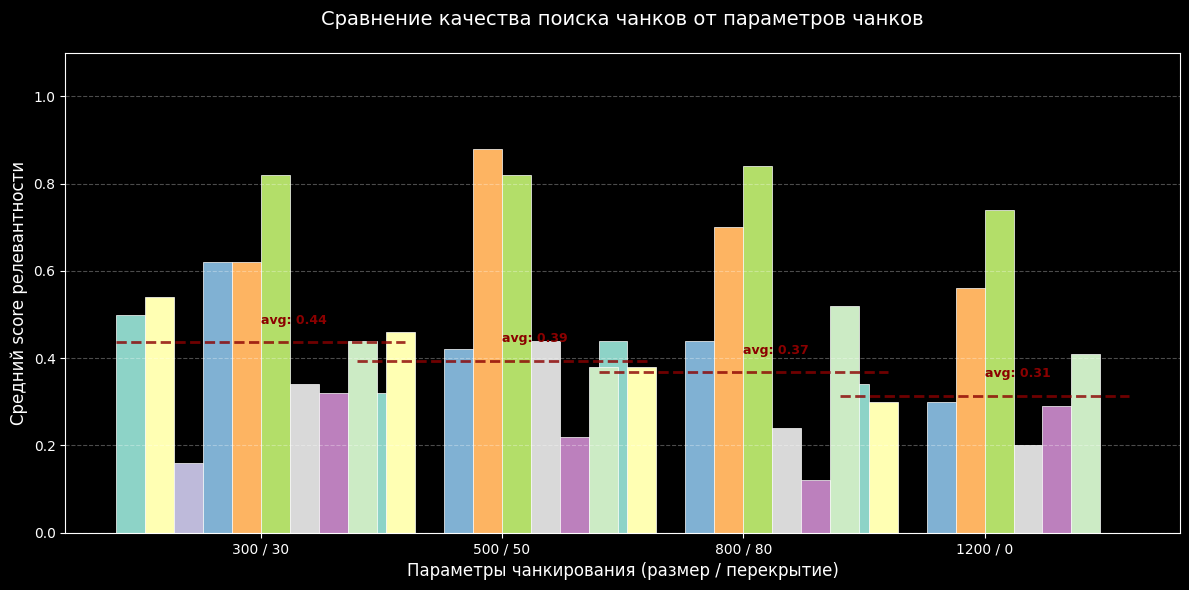

all-MiniLM-L6-v2
Q: Что такое полнота?
 - найден фрагмент (score=0.7289): среднее между полнотой и точностью и часто используется, когда необходимо учесть и полноту, и точность... [docs/ML. Погружение в технологию.pdf стр.62]
 - найден фрагмент (score=0.7363): артем демиденко машинное обучение. погружение в технологию https://t.me/portaltoit... [docs/ML. Погружение в технологию.pdf стр.1]
 - найден фрагмент (score=0.7970): . это множество включает все элементы, которые присутствуют в транзакциях,... [docs/ML. Погружение в технологию.pdf стр.33]
 - найден фрагмент (score=0.8407): определенного заболевания у пациента... [docs/ML. Погружение в технологию.pdf стр.77]
 - найден фрагмент (score=0.8621): . этот подход может быть полезен, если пропущенные значения имеют систематическую зависимость с другими признаками... [docs/ML. Погружение в технологию.pdf стр.56]
Q: Классификация методом бустинга
 - найден фрагмент (score=0.4284): . классификация является одним из самых... [docs/ML. Погруже

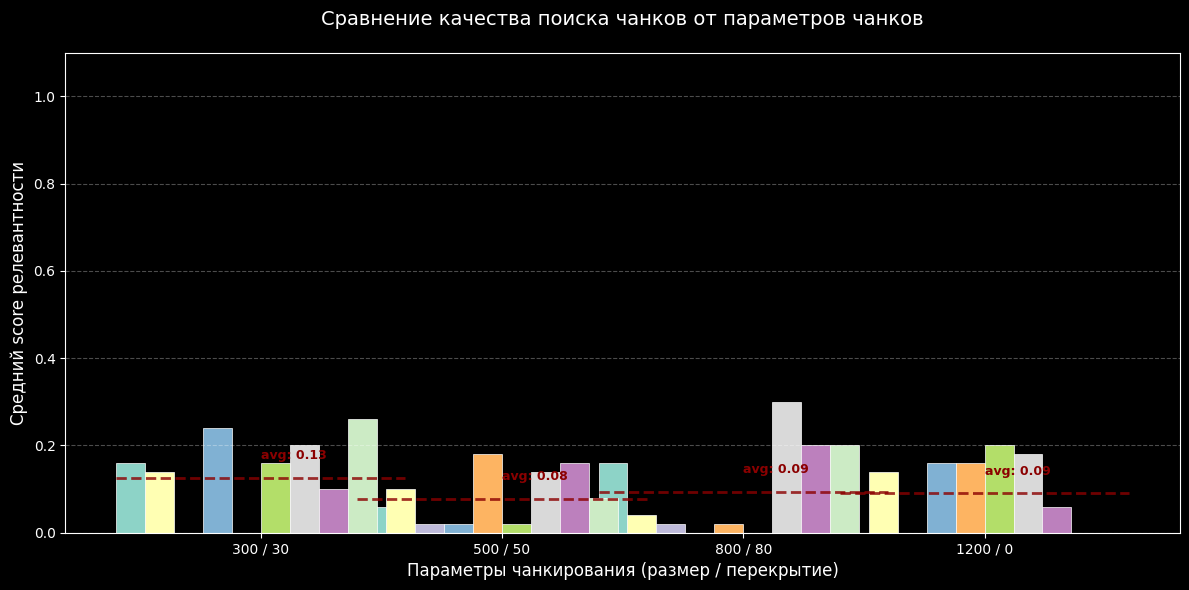

In [3]:
for emb_model in ["intfloat/multilingual-e5-base", "all-MiniLM-L6-v2"]:
    # --- основной цикл эксперимента ---
    print(emb_model)
    embedding_model = HuggingFaceEmbeddings(model_name=emb_model)
    res_rag = {}
    for cfg in configs:
        splitter = make_splitter(cfg)
        chunks = []
        for doc in clean_docs:
            for chunk_text in splitter.split_text(doc.page_content):
                md = (doc.metadata or {}).copy() if hasattr(doc, "metadata") else {}
                chunks.append(Document(page_content=chunk_text, metadata=md))


        db = FAISS.from_documents(chunks, embedding_model)

        for q in questions:
            k = cfg.get("k", 5)
            docs_and_scores = db.similarity_search_with_score(q, k=k)

            parts = []
            print(f"Q: {q}")
            for doc, score in docs_and_scores:
                src = (doc.metadata or {}).get("source", "—")
                page = (doc.metadata or {}).get("page", "—")
                snippet = doc.page_content[:120].replace("\n", " ")
                print(f" - найден фрагмент (score={score:.4f}): {snippet}... [{src} стр.{page}]")
                parts.append(doc.page_content.replace("\n", " "))

            res_rag[(cfg['chunk_size'], cfg['chunk_overlap'], q)] = parts



    load_dotenv('my.env')

    MODEL = os.getenv("MODEL")
    API_KEY = os.getenv("API_KEY")
    API_BASE = os.getenv("API_BASE")

    llm = ChatOpenAI(
        model=MODEL,
        openai_api_key=API_KEY,
        openai_api_base=API_BASE,
        temperature=0,
        request_timeout=15,
    )

    class AnswerInfo(BaseModel):
        score: float = Field(..., description='Скор соответствия запроса и найденного чанка')

    output_parser = PydanticOutputParser(pydantic_object=AnswerInfo)
    format_instructions = output_parser.get_format_instructions()

    prompt = ('Ты строгий контролер соответствия двух текстов. Первый текст - запрос. '
              'Второй текст - найденный другой системой чанк текста. Твоя задача '
              'оценить, насколько второй текст соответствует запросу (первому тексту). '
              'Если второй текст очень близок по смыслу к нему, то верни 1. '
              'Если второй текст совершенно не соответствует запросу - верни 0. \n'
              'Например. \n'
              'Первый текст - **Что такое нейронная сеть?** \n'
              'Если второй текст - **Классификация заявок будет нашей основной темой в следующей главе.** \n'
              'То, поскольку два текста не связаны - верни 0. \n'
              'А если второй текст - **Под нейронной сетью понимается совокупность связанных элементов, называемых нейронами.**'
              ', то поскольку два текста очень близки по смыслу, верни 1 или 0.9.\n'
              'Ты можешь вернуть оценку от 0 до 1. В зависимости от силы схожести.'
              'Формат ответа: {format}'
              'Теперь оцени.\n'
              'Первый текст: {first}.\n'
              'Второй текст: {second}.\n'
              'Score:')

    ch_prompt = PromptTemplate.from_template(prompt)

    score_dict = {}
    for k, vs in res_rag.items():
        prom = []
        for v in vs:
            prompt_text = ch_prompt.format_prompt(format=format_instructions, first=k[2], second=v)
            ai_message = llm.invoke(prompt_text)
            responce = output_parser.invoke(ai_message)
            prom.append(responce.score)

        score_dict[k] = sum(prom)/len(prom)
            # print(responce)

    pass

    # for k, v in score_dict.items():
    #     print(k , round(sum(v)/len(v), 2))

    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(configs))  # позиции групп на оси X
    width = 0.12  # ширина каждого столбика
    multiplier = 0

    # Цветовая палитра
    colors = plt.cm.Set3(np.linspace(0, 1, len(questions)))

    # Строим столбики для каждого вопроса
    for i, question in enumerate(questions):
        # Собираем значения для текущего вопроса по всем группам
        values = [score_dict.get((g[0], g[1], question), 0) for g in groups]

        offset = width * multiplier
        rects = ax.bar(x + offset, values, width, color=colors[i], edgecolor='white', linewidth=0.5)

        multiplier += 1

    # Добавляем средние линии для каждой группы
    for i, group in enumerate(groups):
        # Собираем значения для всех вопросов в текущей группе
        group_values = [score_dict.get((group[0], group[1], q), 0) for q in questions]
        group_mean = np.mean(group_values)

        # Координаты X: от начала первого столбика до конца последнего в группе
        x_start = x[i] - width / 2
        x_end = x[i] + width * (len(questions) - 0.5)

        # Рисуем среднюю линию (красный пунктир)
        ax.hlines(group_mean, x_start, x_end, colors='darkred', linestyles='--', linewidth=2, alpha=0.8)

        # Подпись значения среднего справа от линии
        ax.text((x_start+x_end)/2, group_mean+0.05, f'avg: {group_mean:.2f}',
                va='center', fontsize=9, color='darkred', fontweight='bold')

    # Оформление
    ax.set_xlabel('Параметры чанкирования (размер / перекрытие)', fontsize=12)
    ax.set_ylabel('Средний score релевантности', fontsize=12)
    ax.set_title('Сравнение качества поиска чанков от параметров чанков', fontsize=14, pad=20)
    ax.set_xticks(x + width * (len(questions) - 1) / 2)
    ax.set_xticklabels([f'{g[0]} / {g[1]}' for g in groups])
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()



In [ ]:
# '''Я составил вопросы, просто по смыслу учебника (тема мл). Не всегда эти вопросы прям точно рассматривались в нем.
# Но используя эмбеддинги по умолчанию (all-MiniLM-L6-v2) я увидел просто несвязные чанки.
# Поэтому пришлось искать другую сетку для эмбедингов, и нашел intfloat/multilingual-e5-base, которая выдавала гораздо лучше чанки
# И потом, что бы подтвердить эту гипотезу, я настроил ллм для анализа связности двух текстов - запроса и чанка
# В итоге, лучше всего по графикам, идут более короткие чанки.'''